In [65]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from IPython.display import Audio
import numpy as np
import pandas as pd

In [69]:
SAMPLE_RATE = 16000
N_MELS = 64 
BATCH_SIZE = 32
DATA_DIR = 'audio_data/train/audio'
VAL_LIST = 'audio_data/train/validation_list_with_silence_balanced.txt'
TEST_LIST = 'audio_data/train/testing_list_with_silence_balanced.txt'
TRAIN_LIST = 'audio_data/train/training_list_with_silence_balanced.txt'

class AudioTransform:
    def __init__(self, sample_rate=SAMPLE_RATE, n_mels=N_MELS):
        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=512,
            n_mels=n_mels
        )
        self.db = torchaudio.transforms.AmplitudeToDB()

    def __call__(self, waveform):
        return self.db(self.mel(waveform))

class AudioDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform
        self.fixed_length = 32  # number of time frames

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = self.file_list[idx]
        label = self.labels[idx]
        waveform, sr = torchaudio.load(path)

        # Convert to MelSpectrogram
        mel_spec = T.MelSpectrogram(sample_rate=sr, n_mels=64)(waveform)
        mel_spec = torchaudio.functional.amplitude_to_DB(mel_spec, multiplier=10, db_multiplier=0, amin=1e-10, top_db=80)

        # Fix time dimension by padding or cropping
        if mel_spec.shape[-1] < self.fixed_length:
            pad_width = self.fixed_length - mel_spec.shape[-1]
            mel_spec = F.pad(mel_spec, (0, pad_width))
        else:
            mel_spec = mel_spec[..., :self.fixed_length]

        return mel_spec, label

class CNNClassifier(nn.Module):
    def __init__(self, n_classes, dropout):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # (B, 32, H, W)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                              # (B, 32, H/2, W/2)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B, 64, H/2, W/2)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                              # (B, 64, H/4, W/4)

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (B, 128, H/4, W/4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                              # (B, 128, H/8, W/8)
        )

        self.gap = nn.AdaptiveAvgPool2d((4, 4))  # Ensures consistent output size

        self.fc = nn.Sequential(
            nn.Flatten(),                 # (B, 128*4*4 = 2048)
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.gap(x)
        return self.fc(x)
    
    def train_one_epoch(self, optimizer, train_dl, train_ds, device):
        self.train()
        total_loss, total_correct = 0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            out = self(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item() * xb.size(0)
            total_correct += (out.argmax(1) == yb).sum().item()
        return total_loss / len(train_ds), total_correct / len(train_ds)

    def evaluate(self, dl):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.eval()
        correct = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in dl:
                xb, yb = xb.to(device), yb.to(device)
                out = self(xb)
                preds = out.argmax(1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())
                correct += (preds == yb).sum().item()
        return correct / len(dl.dataset), all_preds, all_labels
    
    def train_cnn(self, epochs, data, learning_rate, weight_decay, device):

        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)

        self.train_accs, self.val_accs = [], []

        for epoch in range(epochs):
            train_loss, train_acc = self.train_one_epoch(optimizer, data.train_dl, data.train_ds, device)
            val_acc, _, _ = self.evaluate(data.val_dl)
            self.train_accs.append(train_acc)
            self.val_accs.append(val_acc)
            print(f"Epoch {epoch+1}: Train acc = {train_acc:.4f}, Val acc = {val_acc:.4f}")

class Data:
    def __init__(self, DATA_DIR, TRAIN_LIST, TEST_LIST, VAL_LIST):
        def load_file_paths(file_list_path, base_dir):
            with open(file_list_path, 'r') as f:
                files = [os.path.join(base_dir, line.strip()) for line in f]
            return files

        train_files = load_file_paths(TRAIN_LIST, DATA_DIR)
        val_files = load_file_paths(VAL_LIST, DATA_DIR)
        test_files = load_file_paths(TEST_LIST, DATA_DIR)

        self.train_files = train_files
        self.val_files = val_files
        self.test_files = test_files

        def map_label(label):
            return label if label in {'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence'} else 'unknown'

        # Extract and map labels from file paths
        train_labels = [map_label(os.path.basename(os.path.dirname(f))) for f in train_files]
        val_labels = [map_label(os.path.basename(os.path.dirname(f))) for f in val_files]
        test_labels = [map_label(os.path.basename(os.path.dirname(f))) for f in test_files]

        self.train_labels = train_labels
        self.val_labels = val_labels
        self.test_labels = test_labels

        labels = list(set(train_labels))
        le = LabelEncoder()
        le.fit(labels)

        self.labels = labels
        self.le = le

        # Encode labels
        train_targets = le.fit_transform(train_labels)
        val_targets = le.transform(val_labels)
        test_targets = le.transform(test_labels)

        # Create datasets
        transform = AudioTransform()
        train_ds = AudioDataset(train_files, train_targets, transform=transform)
        val_ds = AudioDataset(val_files, val_targets, transform=transform)
        test_ds = AudioDataset(test_files, test_targets, transform=transform)

        train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
        test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

        self.train_ds = train_ds
        self.val_ds = val_ds
        self.test_ds = test_ds
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.test_dl = test_dl



In [70]:
data = Data(DATA_DIR, TRAIN_LIST, TEST_LIST, VAL_LIST)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def grid_search(data, device):
    
    epochs = 20
    results = []
    for dropout in [0, 0.1, 0.2, 0.3, 0.4]:
        for learning_rate in [0.001, 0.0005, 0.0001]:
            for weight_decay in [0, 1e-4]:

                print('\ndropout = {}, lr = {}, weight_decay = {}'.format(dropout, learning_rate, weight_decay))

                model = CNNClassifier(n_classes=len(data.labels), dropout=dropout).to(device)
                model.train_cnn(epochs, data, learning_rate, weight_decay, device)

                test_acc, preds, truths = model.evaluate(data.test_dl)

                print('test accuracy: {}'.format(test_acc))

                results.append([epochs, dropout, learning_rate, weight_decay, test_acc])

                results_df = pd.DataFrame(results, columns = ['epochs', 'dropout', 'learning_rate', 'weight_decay', 'test_acc']) 
                results_df.to_csv('results_cnn.csv', index=False)

results = grid_search(data, device)

In [ ]:
# torch.save(model.state_dict(), "cnn_models/cnn_audio_classifier.pt")

In [99]:
dropout = 0.2
epochs = 20
learning_rate = 0.0005
weight_decay = 0.0001

model = CNNClassifier(n_classes=len(data.labels), dropout=dropout).to(device)
model.train_cnn(epochs, data, learning_rate, weight_decay, device)

test_acc, preds, truths = model.evaluate(data.test_dl)

print('test accuracy: {}'.format(test_acc))

Epoch 1: Train acc = 0.3178, Val acc = 0.4055
Epoch 2: Train acc = 0.4532, Val acc = 0.4673
Epoch 3: Train acc = 0.4948, Val acc = 0.4902
Epoch 4: Train acc = 0.5218, Val acc = 0.4885
Epoch 5: Train acc = 0.5392, Val acc = 0.5347
Epoch 6: Train acc = 0.5545, Val acc = 0.5171
Epoch 7: Train acc = 0.5626, Val acc = 0.5340
Epoch 8: Train acc = 0.5762, Val acc = 0.5370
Epoch 9: Train acc = 0.5832, Val acc = 0.5513
Epoch 10: Train acc = 0.5934, Val acc = 0.5480
Epoch 11: Train acc = 0.6001, Val acc = 0.5523
Epoch 12: Train acc = 0.6097, Val acc = 0.5533
Epoch 13: Train acc = 0.6166, Val acc = 0.5447
Epoch 14: Train acc = 0.6259, Val acc = 0.5523
Epoch 15: Train acc = 0.6316, Val acc = 0.5619
Epoch 16: Train acc = 0.6408, Val acc = 0.5586
Epoch 17: Train acc = 0.6481, Val acc = 0.5563
Epoch 18: Train acc = 0.6573, Val acc = 0.5573
Epoch 19: Train acc = 0.6667, Val acc = 0.5636
Epoch 20: Train acc = 0.6769, Val acc = 0.5556
test accuracy: 0.5426098535286284


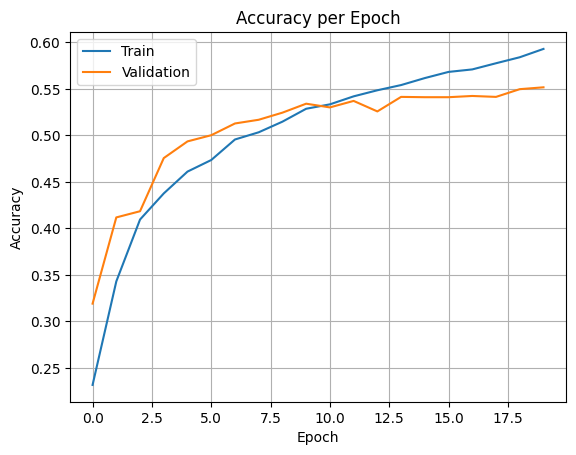

Test Accuracy: 0.5426

Classification Report:

              precision    recall  f1-score   support

        down       0.51      0.53      0.52       253
          go       0.43      0.49      0.46       251
        left       0.64      0.51      0.57       267
          no       0.53      0.49      0.51       252
         off       0.40      0.48      0.43       262
          on       0.50      0.31      0.38       246
       right       0.52      0.66      0.58       259
     silence       1.00      0.99      0.99       200
        stop       0.63      0.71      0.67       249
     unknown       0.43      0.30      0.35       237
          up       0.38      0.53      0.44       272
         yes       0.80      0.59      0.68       256

    accuracy                           0.54      3004
   macro avg       0.56      0.55      0.55      3004
weighted avg       0.56      0.54      0.54      3004



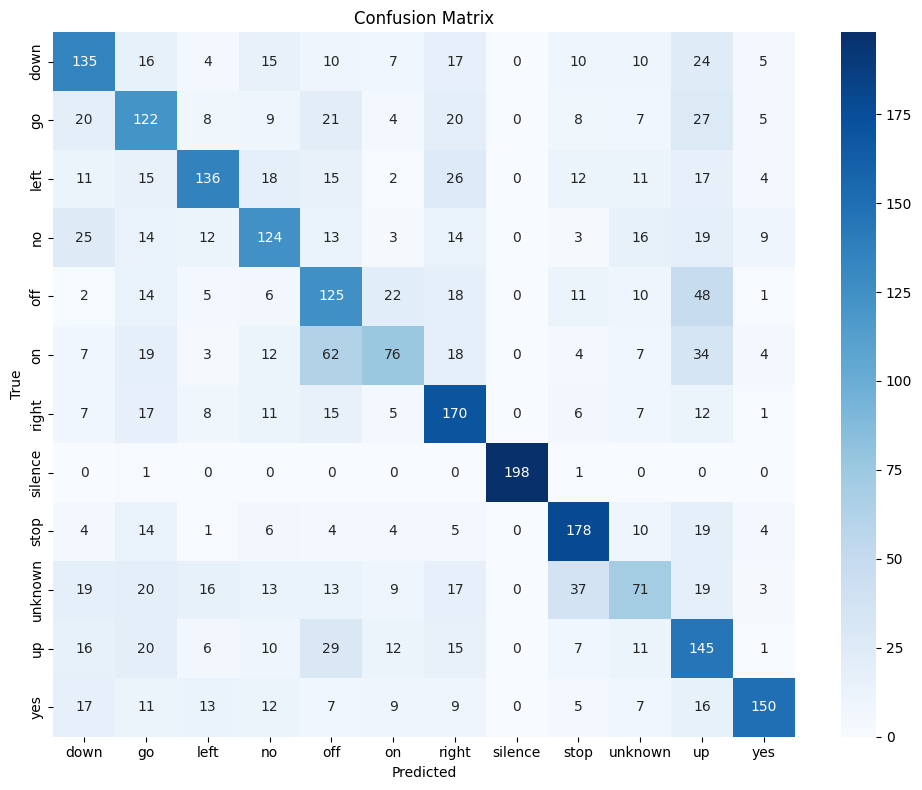

In [101]:
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Validation")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

test_acc, preds, truths = evaluate(test_dl, model)
print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(truths, preds, target_names=le.classes_))

import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(truths, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## TRANSFORMATIONS OVERVIEW

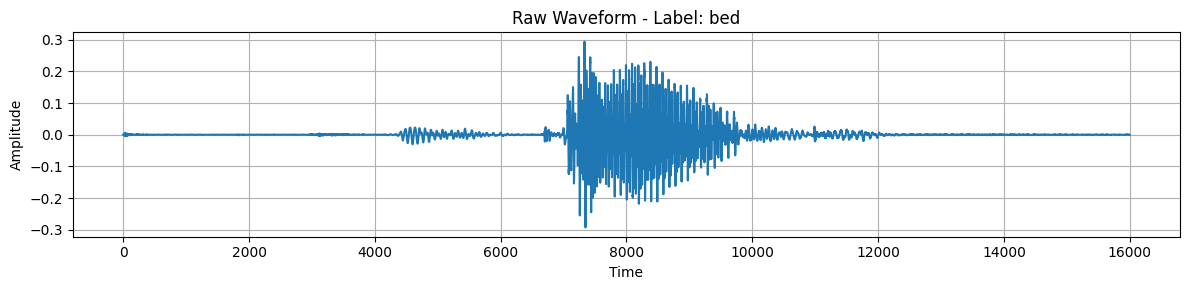

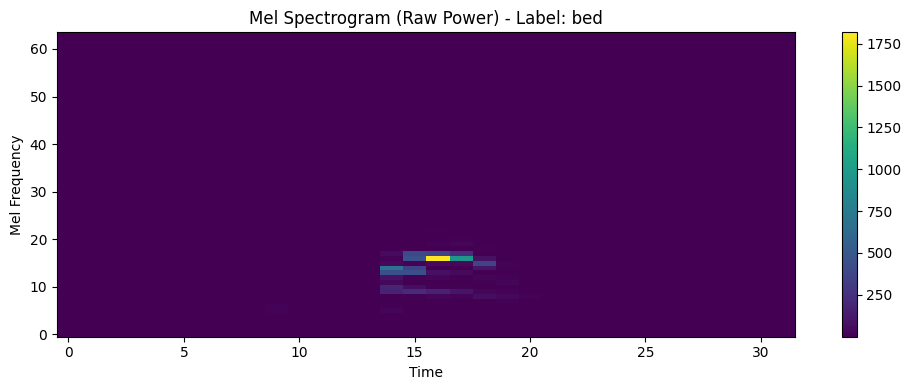

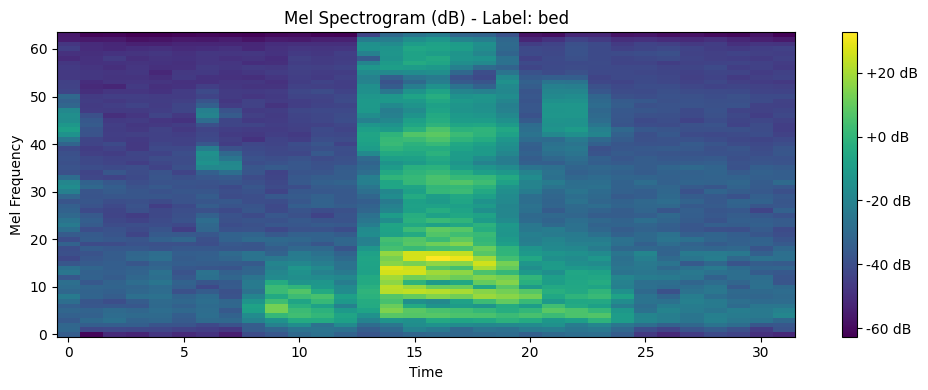

In [ ]:
def show_sample(sample_path):

    # Load the original waveform
    waveform, sample_rate = torchaudio.load(sample_path)

    label = sample_path.split('/')[-2]

    # Initialize mel spectrogram and dB transforms
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=1024,
        hop_length=512,
        n_mels=N_MELS
    )
    db_transform = torchaudio.transforms.AmplitudeToDB()

    # Step 1: Plot raw waveform
    plt.figure(figsize=(12, 3))
    plt.plot(waveform.t().numpy())
    plt.title(f'Raw Waveform - Label: {label}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('images_to_report/raw_waveform_bed.png')
    plt.show()

    # Step 2: Apply MelSpectrogram (before AmplitudeToDB)
    mel_spec = mel_transform(waveform)

    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec.squeeze().numpy(), origin='lower', aspect='auto', cmap='viridis')
    plt.title(f'Mel Spectrogram (Raw Power) - Label: {label}')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig('images_to_report/mel_spectrogram_bed.png')
    plt.show()

    # Step 3: Apply AmplitudeToDB to the Mel Spectrogram
    mel_spec_db = db_transform(mel_spec)

    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec_db.squeeze().numpy(), origin='lower', aspect='auto', cmap='viridis')
    plt.title(f'Mel Spectrogram (dB) - Label: {label}')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig('images_to_report/mel_spectrogram_db_bed.png')
    plt.show()
    

show_sample(f'{DATA_DIR}/bed/0a7c2a8d_nohash_0.wav') 
# show_sample(f'{DATA_DIR}/six/0a7c2a8d_nohash_0.wav') 
